In [1]:
# =========================
# 1️⃣ 기본/유틸리티
# =========================
import os
import sys
import math
import time
import random
import datetime as dt
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

# =========================
# 2️⃣ 데이터 처리
# =========================
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.model_selection import train_test_split
# =========================
# 3️⃣ 시각화
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# =========================
# 4️⃣ 데이터 전처리 / 스케일링
# =========================
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================
# 5️⃣ TensorFlow / Keras (LSTM, CNN-LSTM)
# =========================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model

# =========================
# 6️⃣ PyTorch (옵션, CNN-LSTM 대안 또는 Transformer 시도)
# =========================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# =========================
# 7️⃣ 앙상블 / 메타 모델
# =========================
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

# =========================
# 8️⃣ 추가 유틸
# =========================
import joblib  # 모델 저장/불러오기
import json
import pickle
from tqdm import tqdm  # 진행률 표시

# =========================
# 9️⃣ 시계열 기술지표 (보조 feature)
# =========================
import ta  # RSI, MACD, BollingerBand 등


tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
df = pd.read_csv('btc_15m_with_indicators_FGI.csv')

In [4]:
df.head()

,Open time,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,SMA_7,SMA_14,...,BB_Width,ATR_14,CCI_14,ROC_7,ROC_14,WILLR_14,ADX_7,ADX_pos,ADX_neg,FGI
0,2018-02-01 0:00,10301.14,194.171332,15:00.0,1.998502e+06,1663,115.505862,1.189093e+06,10220.91143,10181.32357,...,237.732189,75.454633,207.529609,1.379295,1.539083,-8.211972,45.726044,31.851123,4.522005,30
1,2018-02-01 0:15,10328.98,145.451513,30:00.0,1.500997e+06,1331,67.016809,6.916635e+05,10239.85429,10191.56643,...,257.166869,72.918587,182.983141,1.300462,1.407873,-2.457143,50.247567,32.344212,4.125303,30
2,2018-02-01 0:30,10243.05,168.708551,45:00.0,1.732231e+06,1712,64.600161,6.630584e+05,10249.87857,10199.23071,...,245.369924,75.919403,85.052773,0.689775,1.058629,-37.530612,45.007747,24.987026,19.016292,30
3,2018-02-01 0:45,10263.18,86.109894,00:00.0,8.838260e+05,1189,32.000214,3.283792e+05,10263.80571,10209.54286,...,245.917810,73.850160,73.775615,0.959010,1.426749,-32.704918,40.516473,22.543152,17.156390,30
4,2018-02-01 1:00,10261.97,113.128935,15:00.0,1.159704e+06,1254,40.641458,4.167431e+05,10272.80429,10218.61214,...,249.836515,72.076577,56.704059,0.617611,1.252787,-33.347032,35.807990,20.143325,17.312736,30


In [5]:
# df = df.drop(columns=['date_utc'])
# ==========================
# 2️⃣ 시간 컬럼 처리 (인덱스로 설정)
# ==========================
df['Open time'] = pd.to_datetime(df['Open time'])
df = df.set_index('Open time')



In [6]:
# ==========================
# 결측치 확인
# ==========================
# 각 컬럼별 결측치 개수
print("컬럼별 결측치 개수:")
print(df.isna().sum())

# 각 컬럼별 결측치 비율 (%)
print("\n컬럼별 결측치 비율 (%):")
print(df.isna().mean() * 100)

# 전체 데이터셋 결측치 총합
print(f"\n전체 결측치 총합: {df.isna().sum().sum()}")

컬럼별 결측치 개수:
Close                           0
Volume                          0
Close time                      0
Quote asset volume              0
Number of trades                0
Taker buy base asset volume     0
Taker buy quote asset volume    0
SMA_7                           0
SMA_14                          0
EMA_7                           0
EMA_14                          0
STO_K                           0
STO_D                           0
STO_RSI_K                       0
STO_RSI_D                       0
OBV                             0
MFI_14                          0
VWAP                            0
BB_Middle                       0
BB_Upper                        0
BB_Lower                        0
BB_Width                        0
ATR_14                          0
CCI_14                          0
ROC_7                           0
ROC_14                          0
WILLR_14                        0
ADX_7                           0
ADX_pos                         0
AD

In [7]:
for col in ['Gold_close', 'value']:
    if col in df.columns:
        df[col] = df[col].ffill().bfill().fillna(df[col].mean())


In [8]:
df = df.drop(columns='value_classification')

KeyError: "['value_classification'] not found in axis"

In [9]:
# ==========================
# 3️⃣ 숫자형 컬럼만 선택
# ==========================
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df_numeric = df[numeric_cols]

# ==========================
# 4️⃣ MinMaxScaler 적용
# ==========================
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric),
                         columns=numeric_cols,
                         index=df.index)

# ==========================
# 5️⃣ 결과 확인
# ==========================
df_scaled.head()

,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,SMA_7,SMA_14,EMA_7,EMA_14,...,BB_Width,ATR_14,CCI_14,ROC_7,ROC_14,WILLR_14,ADX_7,ADX_pos,ADX_neg,FGI
Open time,,,,,,,,,,,,,,,,,,,,,
2018-02-01 00:00:00,0.058922,0.004810,0.002230,0.002743,0.005797,0.002116,0.058437,0.058139,0.058564,0.058298,...,0.017158,0.036657,0.722353,0.422322,0.543970,0.917880,0.440535,0.359736,0.049985,0.277778
2018-02-01 00:15:00,0.059152,0.003603,0.001675,0.002196,0.003363,0.001231,0.058594,0.058224,0.058764,0.058447,...,0.018593,0.035345,0.696053,0.420886,0.541912,0.975429,0.492552,0.365341,0.045455,0.277778
2018-02-01 00:30:00,0.058442,0.004179,0.001933,0.002824,0.003242,0.001180,0.058677,0.058288,0.058737,0.058481,...,0.017722,0.036897,0.591128,0.409765,0.536435,0.624694,0.432272,0.281714,0.215472,0.277778
2018-02-01 00:45:00,0.058609,0.002133,0.000986,0.001961,0.001606,0.000584,0.058793,0.058373,0.058758,0.058532,...,0.017762,0.035827,0.579045,0.414668,0.542208,0.672951,0.380603,0.253935,0.194237,0.277778
2018-02-01 01:00:00,0.058599,0.002802,0.001294,0.002069,0.002040,0.000742,0.058867,0.058449,0.058771,0.058576,...,0.018052,0.034909,0.560754,0.408451,0.539480,0.666530,0.326436,0.226657,0.196022,0.277778


In [10]:
# 전체 데이터를 먼저 85% / 15%로 나눠서 Test 확보
train_val_df, test_df = train_test_split(df_scaled, test_size=0.15, shuffle=False)

# train_val을 82.35% / 17.65%로 나눠서 Train/Validation 비율 맞춤
# 계산: 0.15 / 0.85 ≈ 0.1765
train_df, val_df = train_test_split(train_val_df, test_size=0.1765, shuffle=False)

print(f"Train shape: {train_df.shape}, Val shape: {val_df.shape}, Test shape: {test_df.shape}")

Train shape: (185500, 30), Val shape: (39759, 30), Test shape: (39752, 30)


In [11]:

seq_len = 6

def create_window_sequences(df, seq_len, predict_col='Close'):
    values = df.values
    X, y = [], []
    predict_idx = df.columns.get_loc(predict_col)

    for i in range(seq_len, len(values)):
        X.append(values[i-seq_len:i])
        y.append(values[i, predict_idx])

    return np.array(X), np.array(y)



In [12]:

X_train, y_train = create_window_sequences(train_df, seq_len)
X_val, y_val = create_window_sequences(val_df, seq_len)
X_test, y_test = create_window_sequences(test_df, seq_len)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (185494, 6, 30), y_train: (185494,)
X_val: (39753, 6, 30), y_val: (39753,)
X_test: (39746, 6, 30), y_test: (39746,)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))  # 다음 날 Close 예측
    model.compile(optimizer=Adam(learning_rate=0.005889363347033941), loss='mse', metrics=['mae'])
    return model

lstm_model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          24,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,385 (95.25 KB)

 Trainable params: 24,385 (95.25 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, TimeDistributed, Reshape

def build_cnn_lstm_model(input_shape):
    model = Sequential()
    # CNN 레이어
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    # LSTM 레이어
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

cnn_lstm_model = build_cnn_lstm_model((X_train.shape[1], X_train.shape[2]))
cnn_lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 4, 32)               │           2,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 2, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,809 (108.63 KB)

 Trainable params: 27,809 (108.63 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# LSTM 학습
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)



Epoch 1/100
5797/5797 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 2.7279e-04 - mae: 0.0096 - val_loss: 2.2245e-05 - val_mae: 0.0032
Epoch 2/100
5797/5797 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.2139e-04 - mae: 0.0079 - val_loss: 3.0276e-05 - val_mae: 0.0041
Epoch 3/100
5797/5797 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.1617e-04 - mae: 0.0077 - val_loss: 2.3492e-05 - val_mae: 0.0033
Epoch 4/100
5797/5797 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.0832e-04 - mae: 0.0074 - val_loss: 1.3381e-04 - val_mae: 0.0099
Epoch 5/100
5797/5797 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.0702e-04 - mae: 0.0073 - val_loss: 1.8526e-05 - val_mae: 0.0029
Epoch 6/100
5797/5797 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.0500e-04 - mae: 0.0072 - val_loss: 2.9926e-05 - val_mae: 0.0037
Epoch 7/100
5797/5797 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.0153e-04 - mae: 0.0071 - val_loss: 3.3942e-05 - val_mae: 0.0051
Epoch 8/100
5797/5797 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 1.0074e-04 - mae: 0.0071 - val_los

In [22]:
# CNN-LSTM 학습
cnn_lstm_history = cnn_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0076 - mae: 0.0609 - val_loss: 0.0061 - val_mae: 0.0743
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - mae: 0.0237 - val_loss: 0.0015 - val_mae: 0.0349
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5863e-04 - mae: 0.0193 - val_loss: 7.6388e-04 - val_mae: 0.0231
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7893e-04 - mae: 0.0173 - val_loss: 7.1341e-04 - val_mae: 0.0225
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3825e-04 - mae: 0.0163 - val_loss: 4.8072e-04 - val_mae: 0.0170
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2013e-04 - mae: 0.0146 - val_loss: 2.9150e-04 - val_mae: 0.0126
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6284e-04 - mae: 0.0150 - val_loss: 5.1102e-04 - val_mae: 0.0181
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2082e-04 - mae: 0.0143 - val_loss: 5.7008e-04 - val_mae: 0.0197
Epoch 9/100
61/6

In [25]:
# ==========================
# LSTM 모델 성능 평가
# ==========================
val_loss_lstm, val_mae_lstm = lstm_model.evaluate(X_val, y_val, verbose=0)
test_loss_lstm, test_mae_lstm = lstm_model.evaluate(X_test, y_test, verbose=0)

print(f"LSTM 검증 손실(MSE): {val_loss_lstm:.6f}, MAE: {val_mae_lstm:.6f}")
print(f"LSTM 테스트 손실(MSE): {test_loss_lstm:.6f}, MAE: {test_mae_lstm:.6f}")


LSTM 검증 손실(MSE): 0.000003, MAE: 0.001190
LSTM 테스트 손실(MSE): 0.013467, MAE: 0.089892


In [17]:

# ==========================
# CNN-LSTM 모델 성능 평가
# ==========================
val_loss_cnn_lstm, val_mae_cnn_lstm = cnn_lstm_model.evaluate(X_val, y_val, verbose=0)
test_loss_cnn_lstm, test_mae_cnn_lstm = cnn_lstm_model.evaluate(X_test, y_test, verbose=0)

print(f"CNN-LSTM 검증 손실(MSE): {val_loss_cnn_lstm:.6f}, MAE: {val_mae_cnn_lstm:.6f}")
print(f"CNN-LSTM 테스트 손실(MSE): {test_loss_cnn_lstm:.6f}, MAE: {test_mae_cnn_lstm:.6f}")


CNN-LSTM 검증 손실(MSE): 0.156035, MAE: 0.368476
CNN-LSTM 테스트 손실(MSE): 0.597709, MAE: 0.756320


1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step
1243/1243 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step


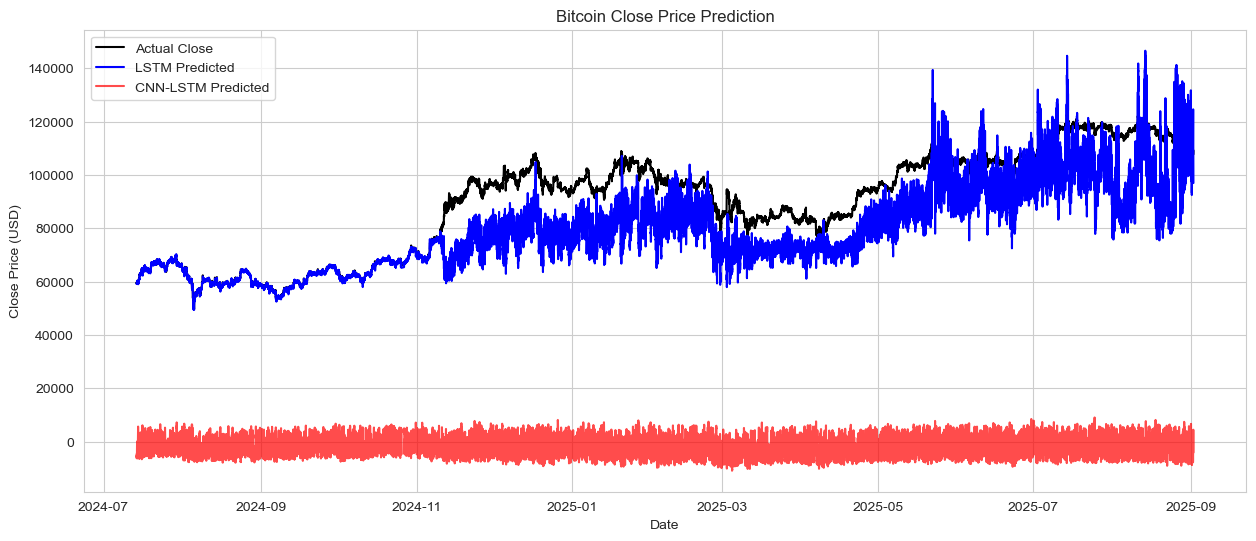

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================
# y_true, y_pred 복원
# ==========================
close_idx = df_scaled.columns.get_loc("Close")

# 실제 값 복원
y_true_real = scaler.inverse_transform(
    np.concatenate([
        np.zeros((len(y_test), close_idx)),
        y_test.reshape(-1,1),
        np.zeros((len(y_test), df_scaled.shape[1]-close_idx-1))
    ], axis=1)
)[:, close_idx]

# LSTM 예측 복원
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm_real = scaler.inverse_transform(
    np.concatenate([
        np.zeros((len(y_pred_lstm), close_idx)),
        y_pred_lstm,
        np.zeros((len(y_pred_lstm), df_scaled.shape[1]-close_idx-1))
    ], axis=1)
)[:, close_idx]

# CNN-LSTM 예측 복원
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test)
y_pred_cnn_lstm_real = scaler.inverse_transform(
    np.concatenate([
        np.zeros((len(y_pred_cnn_lstm), close_idx)),
        y_pred_cnn_lstm,
        np.zeros((len(y_pred_cnn_lstm), df_scaled.shape[1]-close_idx-1))
    ], axis=1)
)[:, close_idx]


# ==========================
# 테스트셋 인덱스 복원 (윈도우 마지막 날짜들)
# ==========================
test_dates = df.index[-len(y_test):]  # X_test에 대응하는 날짜 추출

# ==========================
# 시각화
# ==========================
plt.figure(figsize=(15,6))
plt.plot(test_dates, y_true_real, label='Actual Close', color='black')
plt.plot(test_dates, y_pred_lstm_real, label='LSTM Predicted', color='blue')
plt.plot(test_dates, y_pred_cnn_lstm_real, label='CNN-LSTM Predicted', color='red', alpha=0.7)
plt.title('Bitcoin Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()


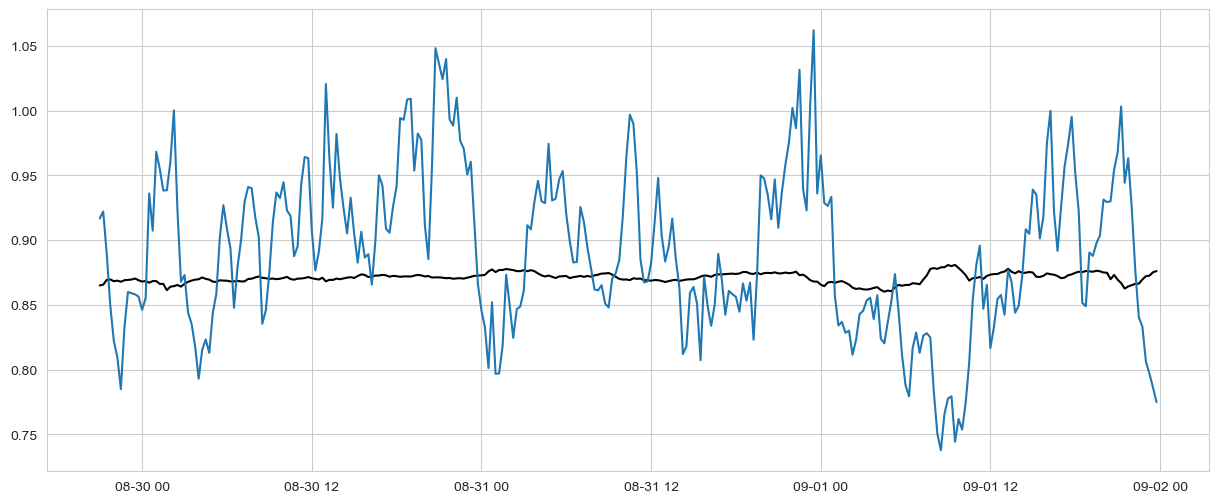

In [23]:

plt.figure(figsize=(15,6))
plt.plot(test_dates[-300:], y_test[-300:], label='Actual Close', color='black')
plt.plot(test_dates[-300:],y_pred_lstm[-300:], label='lstm close')
plt.show()

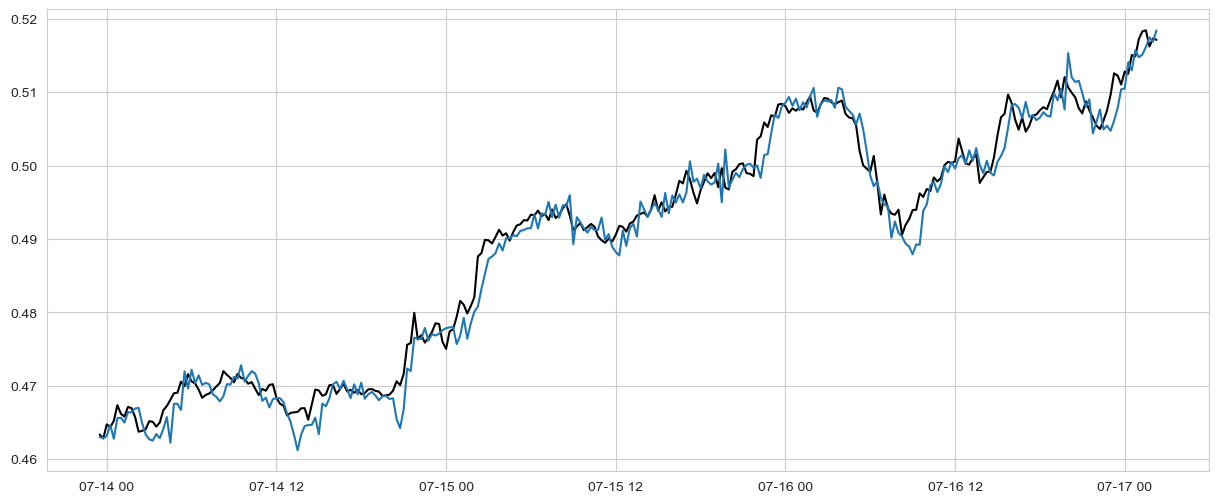

In [24]:

plt.figure(figsize=(15,6))
plt.plot(test_dates[:300], y_test[:300], label='Actual Close', color='black')
plt.plot(test_dates[:300:],y_pred_lstm[:300], label='lstm close')
plt.show()

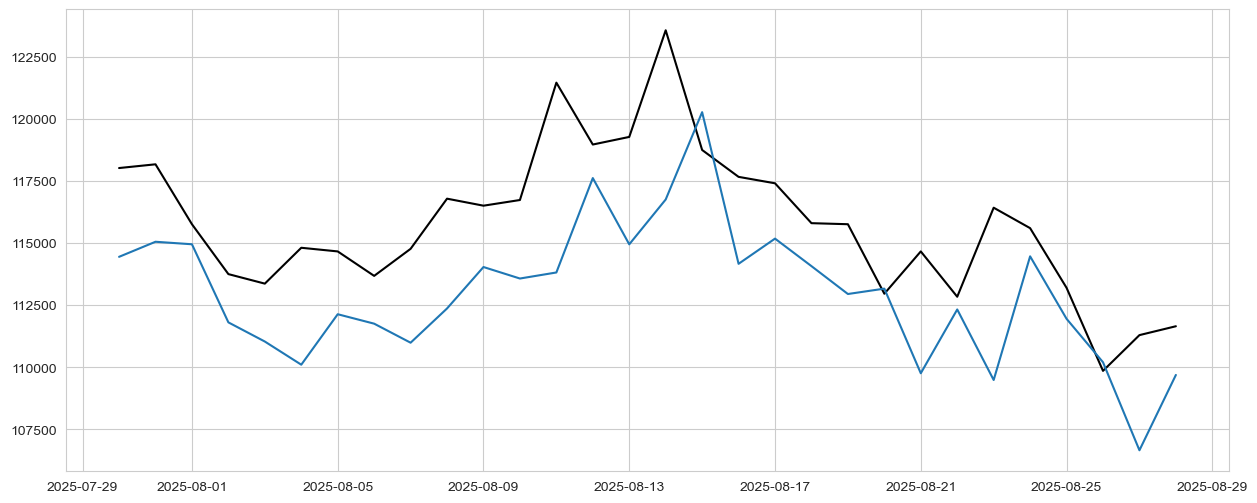

In [32]:

plt.figure(figsize=(15,6))
plt.plot(test_dates[-30:], y_true_real[-30:], label='Actual Close', color='black')
plt.plot(test_dates[-30:],y_pred_lstm_real[-30:])


In [44]:
train_idx = df_scaled.index[:len(y_train)]
val_idx   = df_scaled.index[len(y_train): len(y_train)+len(y_val)]


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


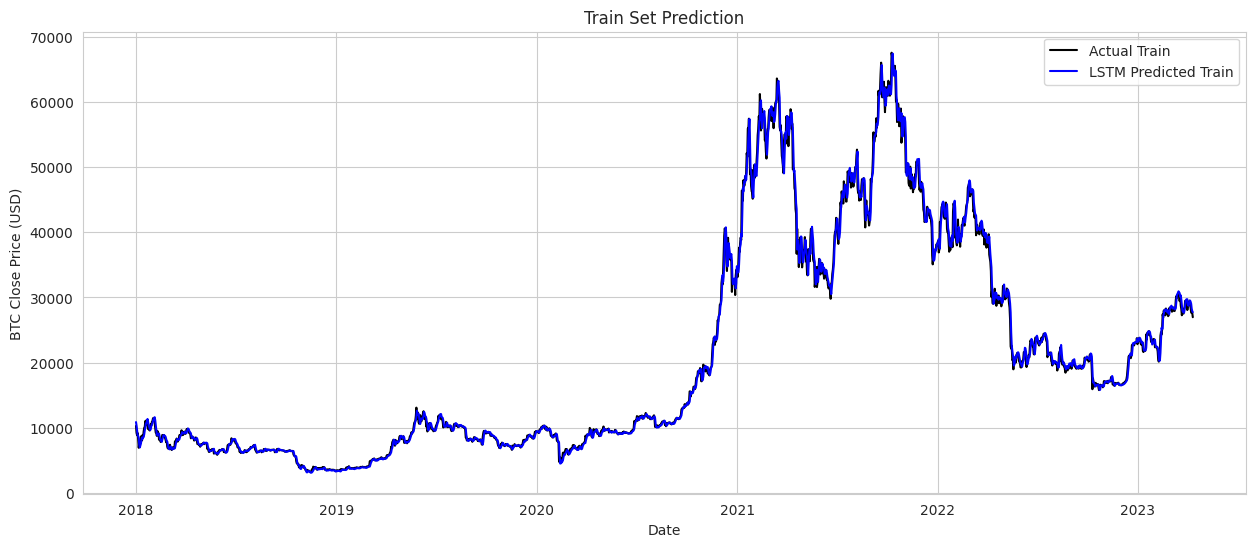

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


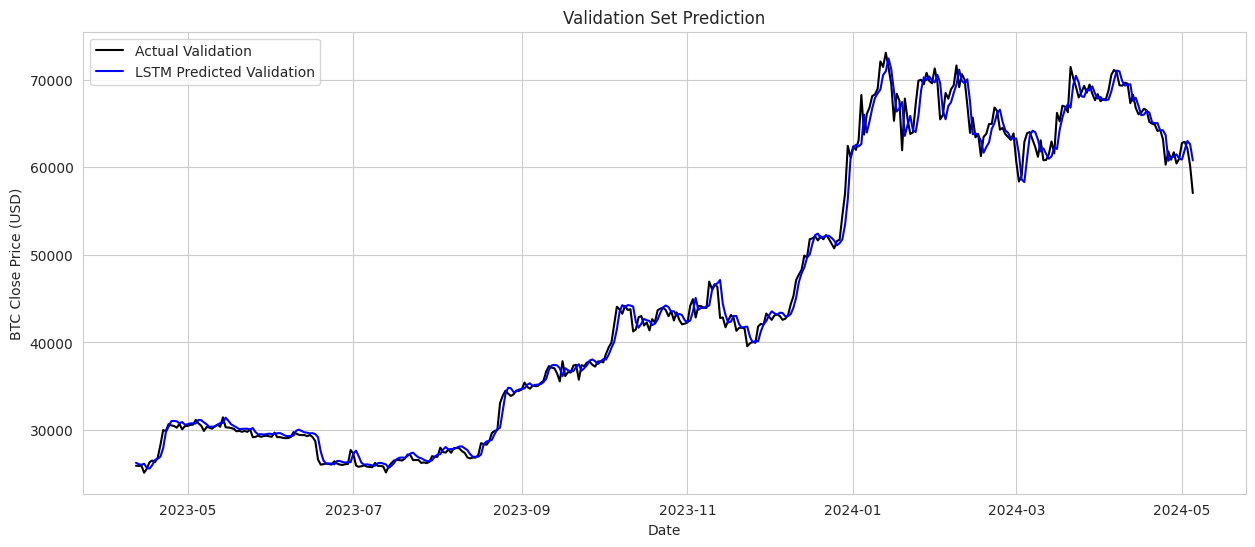

In [45]:
import matplotlib.pyplot as plt

# ==========================
# 1️⃣ Train 예측
# ==========================
y_pred_train = lstm_model.predict(X_train)
y_pred_train_real = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_pred_train), close_idx)),
                    y_pred_train,
                    np.zeros((len(y_pred_train), df_scaled.shape[1]-close_idx-1))], axis=1)
)[:, close_idx]

y_true_train_real = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_train), close_idx)),
                    y_train.reshape(-1,1),
                    np.zeros((len(y_train), df_scaled.shape[1]-close_idx-1))], axis=1)
)[:, close_idx]

plt.figure(figsize=(15,6))
plt.plot(train_idx, y_true_train_real, label='Actual Train', color='black')
plt.plot(train_idx, y_pred_train_real, label='LSTM Predicted Train', color='blue')
plt.title('Train Set Prediction')
plt.xlabel('Date')
plt.ylabel('BTC Close Price (USD)')
plt.legend()
plt.show()

# ==========================
# 2️⃣ Validation 예측
# ==========================
y_pred_val = lstm_model.predict(X_val)
y_pred_val_real = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_pred_val), close_idx)),
                    y_pred_val,
                    np.zeros((len(y_pred_val), df_scaled.shape[1]-close_idx-1))], axis=1)
)[:, close_idx]

y_true_val_real = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y_val), close_idx)),
                    y_val.reshape(-1,1),
                    np.zeros((len(y_val), df_scaled.shape[1]-close_idx-1))], axis=1)
)[:, close_idx]

plt.figure(figsize=(15,6))
plt.plot(val_idx, y_true_val_real, label='Actual Validation', color='black')
plt.plot(val_idx, y_pred_val_real, label='LSTM Predicted Validation', color='blue')
plt.title('Validation Set Prediction')
plt.xlabel('Date')
plt.ylabel('BTC Close Price (USD)')
plt.legend()
plt.show()


In [46]:
!pip install --upgrade xgboost

In [48]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# ==========================
# 1. Base 모델 예측값 생성
# ==========================
y_train_pred_lstm = lstm_model.predict(X_train)
y_val_pred_lstm   = lstm_model.predict(X_val)
y_test_pred_lstm  = lstm_model.predict(X_test)

y_train_pred_cnn  = cnn_lstm_model.predict(X_train)
y_val_pred_cnn    = cnn_lstm_model.predict(X_val)
y_test_pred_cnn   = cnn_lstm_model.predict(X_test)

# ==========================
# 2. 스태킹 데이터셋 만들기
# ==========================
stacked_X_train = np.hstack([y_train_pred_lstm, y_train_pred_cnn])
stacked_X_val   = np.hstack([y_val_pred_lstm, y_val_pred_cnn])
stacked_X_test  = np.hstack([y_test_pred_lstm, y_test_pred_cnn])

stacked_y_train = y_train
stacked_y_val   = y_val
stacked_y_test  = y_test

# ==========================
# 3. 메타모델 (XGBoost)
# ==========================
meta_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

meta_model.fit(stacked_X_train, stacked_y_train)

# ==========================
# 4. 최종 예측
# ==========================
y_val_pred_stack  = meta_model.predict(stacked_X_val)
y_test_pred_stack = meta_model.predict(stacked_X_test)

# ==========================
# 5. 성능 평가
# ==========================
val_mse = mean_squared_error(stacked_y_val, y_val_pred_stack)
val_mae = mean_absolute_error(stacked_y_val, y_val_pred_stack)

test_mse = mean_squared_error(stacked_y_test, y_test_pred_stack)
test_mae = mean_absolute_error(stacked_y_test, y_test_pred_stack)

print(f"스태킹(XGBoost) 검증 MSE: {val_mse:.4f}, MAE: {val_mae:.4f}")
print(f"스태킹(XGBoost) 테스트 MSE: {test_mse:.4f}, MAE: {test_mae:.4f}")


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
스태킹(XGBoost) 검증 MSE: 0.0004, MAE: 0.0136
스태킹(XGBoost) 테스트 MSE: 0.0735, MAE: 0.2304


In [13]:
import optuna

In [14]:
def objective(trial):
    """Optuna가 최적의 하이퍼파라미터를 찾기 위해 실행하는 함수"""
    
    # ==========================
    # 1. 튜닝할 하이퍼파라미터 정의
    # ==========================
    seq_len = trial.suggest_int('seq_len', 5, 30)
    # LSTM 레이어 수
    n_layers = trial.suggest_int('n_layers', 1, 3)
    # 각 LSTM 레이어의 유닛 수
    lstm_units = trial.suggest_int('lstm_units', 32, 256, step=32)
    # Dropout 비율
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    # 학습률 (Learning Rate)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    # 배치 사이즈
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])


    X_train, y_train = create_window_sequences(train_df, seq_len)
    X_val, y_val = create_window_sequences(val_df, seq_len)

    # 만약 제안된 seq_len이 너무 길어서 validation set을 만들 수 없는 경우,
    # 해당 trial을 중단하고 다음 trial로 넘어갑니다 (Pruning).
    if len(X_val) == 0:
        raise optuna.exceptions.TrialPruned()
    
    # ==========================
    # 2. 모델 구성
    # ==========================
    model = Sequential()
    
    # 동적으로 LSTM 레이어 추가
    for i in range(n_layers):
        # 마지막 레이어가 아니면 return_sequences=True
        return_sequences = (i < n_layers - 1)
        if i == 0: # 첫 번째 레이어는 input_shape 지정
            model.add(LSTM(units=lstm_units, return_sequences=return_sequences, 
                           input_shape=(X_train.shape[1], X_train.shape[2])))
        else:
            model.add(LSTM(units=lstm_units, return_sequences=return_sequences))
        model.add(Dropout(dropout_rate))
            
    model.add(Dense(1, activation='linear'))

    # ==========================
    # 3. 모델 컴파일
    # ==========================
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    # ==========================
    # 4. 모델 학습
    # ==========================
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0  # 학습 과정 출력 생략
    )
    
    # ==========================
    # 5. 검증 데이터로 성능 평가 후 결과 반환
    # ==========================
    val_loss, _ = model.evaluate(X_val, y_val, verbose=0)
    
    return val_loss # 최소화할 목표인 검증 손실(MSE)을 반환

In [15]:
# ==============================================================================
# Optuna Study 생성 및 최적화 실행
# ==============================================================================

# Study 객체 생성. 'minimize'는 objective 함수가 반환하는 값을 최소화하는 것을 목표로 함
study = optuna.create_study(direction='minimize')

# n_trials 만큼 최적화 시도
# 시간을 절약하기 위해 50회로 설정했지만, 더 나은 결과를 위해 100회 이상 시도하는 것을 권장합니다.
study.optimize(objective, n_trials=100) # 600초(10분) 제한 추가 가능

[I 2025-09-10 11:25:18,648] A new study created in memory with name: no-name-452dacf3-42bd-42fb-89d2-8cba8b9afc0f
[I 2025-09-10 11:25:59,966] Trial 0 finished with value: 0.00023292854893952608 and parameters: {'seq_len': 27, 'n_layers': 2, 'lstm_units': 224, 'dropout_rate': 0.14478877514636035, 'learning_rate': 0.005780387573741923, 'batch_size': 32}. Best is trial 0 with value: 0.00023292854893952608.
[I 2025-09-10 11:26:24,582] Trial 1 finished with value: 0.00014812768495175987 and parameters: {'seq_len': 21, 'n_layers': 1, 'lstm_units': 160, 'dropout_rate': 0.3324204224623587, 'learning_rate': 0.0006272402320939649, 'batch_size': 32}. Best is trial 1 with value: 0.00014812768495175987.
[I 2025-09-10 11:27:25,678] Trial 2 finished with value: 0.00019052429706789553 and parameters: {'seq_len': 19, 'n_layers': 2, 'lstm_units': 256, 'dropout_rate': 0.3538808114526065, 'learning_rate': 0.000500304526889798, 'batch_size': 64}. Best is trial 1 with value: 0.00014812768495175987.
[I 2025-

In [16]:
# ==============================================================================
# 최적화 결과 확인
# ==============================================================================
print("\n" + "="*50)
print("하이퍼파라미터 튜닝 결과")
print("="*50)
print(f"총 Trial 횟수: {len(study.trials)}")
print(f"최적의 Trial: ")
best_trial = study.best_trial
print(f"  - 값 (Validation Loss): {best_trial.value:.6f}")
print(f"  - 최적 파라미터:")
for key, value in best_trial.params.items():
    print(f"    - {key}: {value}")


하이퍼파라미터 튜닝 결과
총 Trial 횟수: 100
최적의 Trial: 
  - 값 (Validation Loss): 0.000107
  - 최적 파라미터:
    - seq_len: 6
    - n_layers: 1
    - lstm_units: 96
    - dropout_rate: 0.16103971350555243
    - learning_rate: 0.005889363347033941
    - batch_size: 32
